In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (12,6)

In [2]:
def show_image(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [3]:
IMAGE_NAME = 'temp2.jpg'

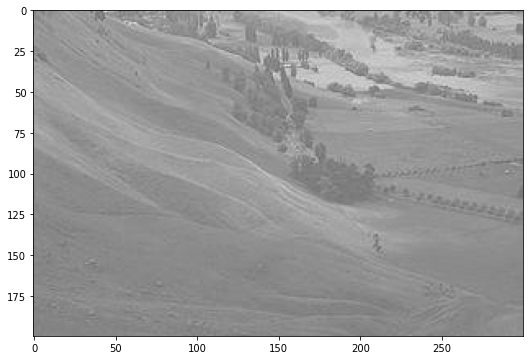

In [4]:
image = cv2.imread(IMAGE_NAME, 0)
show_image(image)

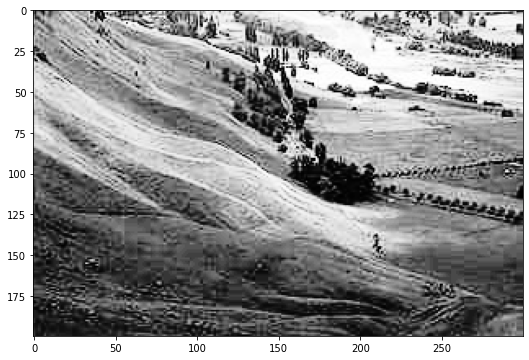

In [5]:
# global equalization

equ = cv2.equalizeHist(image)
show_image(equ)

In [99]:
# local equalization

def local_histo_eq(image):
    kernel_size = (3, 3)
    off = (int(kernel_size[0] / 2), int(kernel_size[1] / 2))
    result = np.zeros((image.shape[0], image.shape[1])).astype(np.uint8)

    for i in range(off[0], image.shape[0] - off[0]):
        for j in range(off[1], image.shape[1] - off[1]):
            x_down = i - off[0]
            x_up = i + off[0] + 1
            y_down = j - off[1]
            y_up = j + off[1] + 1
            part = image[x_down: x_up, y_down: y_up]

            result[x_down: x_up, y_down: y_up] = cv2.equalizeHist(part)
    
    return result

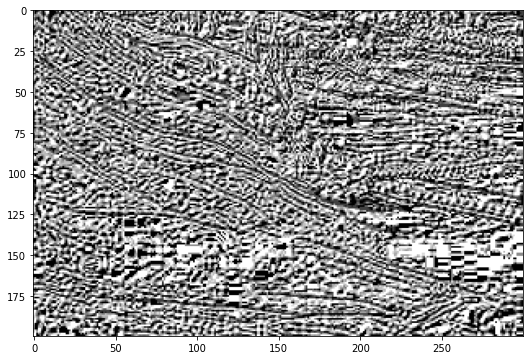

In [100]:
show_image(local_histo_eq(image))

In [6]:
def add_sp_noise(image, snr=0.99):
    noise = image.copy()
    salt_vs_pepper = 0.5

    num_salt = np.ceil((1 - snr) * image.size * salt_vs_pepper)
    num_pepper = np.ceil((1 - snr) * image.size * (1. - salt_vs_pepper))

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noise[coords] = 255
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noise[coords] = 0

    return noise

<ipython-input-6-4a4dc93209d2>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noise[coords] = 255
<ipython-input-6-4a4dc93209d2>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noise[coords] = 0


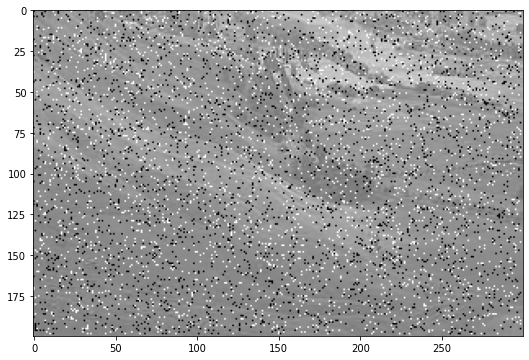

In [7]:
noise = add_sp_noise(image, 0.9)
show_image(noise)

In [10]:
def median_filter(noise):
    kernel = (3, 3)
    off = (int(kernel[0] / 2), int(kernel[1] / 2))
    denoise = image.copy()

    for i in range(off[0], image.shape[0] - off[0]):
        for j in range(off[1], image.shape[1] - off[1]):
            x_down = i - off[0]
            x_up = i + off[0] + 1
            y_down = j - off[1]
            y_up = j + off[1] + 1
            part = image[x_down: x_up, y_down: y_up]

            med = np.median(part)
            denoise[i][j] = med
    
    return denoise

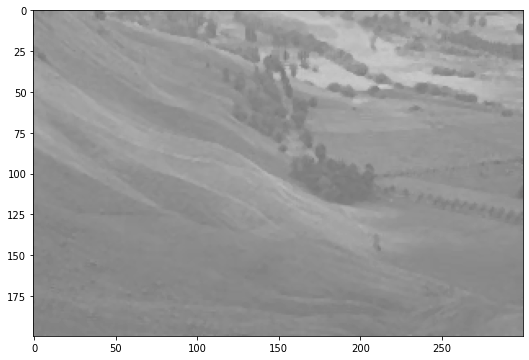

In [11]:
show_image(median_filter(noise))

In [95]:
def convolution(oldimage, kernel):
    image_h = oldimage.shape[0]
    image_w = oldimage.shape[1]
    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    if(len(oldimage.shape) == 3):
        image_pad = np.pad(oldimage, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2),(0,0)), mode='constant', constant_values=0).astype(np.float32)    
    elif(len(oldimage.shape) == 2):
        image_pad = np.pad(oldimage, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2)), mode='constant', constant_values=0).astype(np.float32)
    
    h = kernel_h // 2
    w = kernel_w // 2
    
    image_conv = np.zeros(image_pad.shape)
    
    for i in range(h, image_pad.shape[0]-h):
        for j in range(w, image_pad.shape[1]-w):
            x = image_pad[i-h:i-h+kernel_h, j-w:j-w+kernel_w]
            x = x.flatten()*kernel.flatten()
            image_conv[i][j] = x.sum()
            
    h_end = -h
    w_end = -w
    
    if(h == 0):
        return image_conv[h:,w:w_end]
    if(w == 0):
        return image_conv[h:h_end,w:]
    return image_conv[h:h_end,w:w_end]

In [96]:
def GaussianBlurImage(image, sigma):
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
    m = filter_size // 2
    n = filter_size // 2
    
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1 = 2 * np.pi * (sigma ** 2)
            x2 = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
            gaussian_filter[x + m, y + n] = (1 / x1) * x2
    
    im_filtered = np.zeros_like(image, dtype=np.float32)
    
    im_filtered = convolution(image, gaussian_filter)
        
    return (im_filtered.astype(np.uint8))

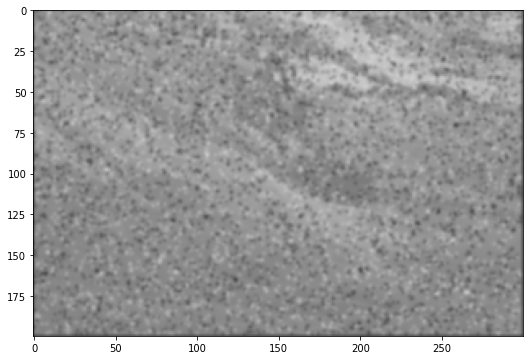

In [97]:
show_image(GaussianBlurImage(noise, 1))